#Homework 9: Neural Network by Hands
In this homework, you will work on the classification task with three synthetical datasets: Noisy Moons, Noisy Circles, and a multipetal rose.

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split

In [73]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros(m, dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius. 4 corresponds to the number of petals
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

In [74]:
x, y = load_planar_dataset()  #make_moons(n_samples=200, noise=0.1)  make_circles(n_samples=200, noise=0.1)
y = y.reshape(-1,1)
x.shape, y.shape


((400, 2), (400, 1))

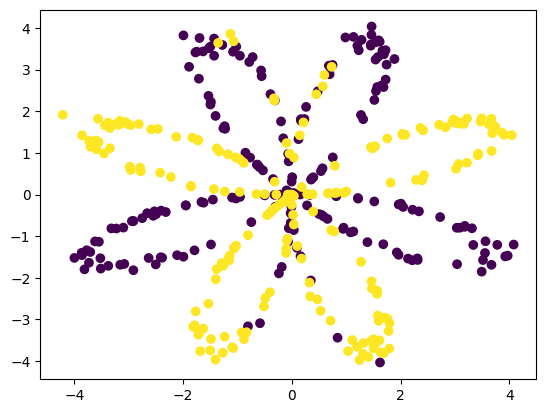

In [75]:
plt.scatter(x[:,0], x[:,1], c=y)

Below is the model from the class: $x\to h\to a=\sigma(h)\to o\to Loss(o,y)$, where $Loss$ is MSE:
$$
Loss(o,y) = \frac{1}{N} \sum_{i=1}^{N}\left( o^{(i)}-y^{(i)}\right)^2.
$$

For the binary classification we use binary cross-entropy loss:
$$
Loss(\sigma(o^{(i)}),y^{(i)}) = -\frac{1}{N}\sum_{i=1}^{N}\left( y^{(i)}\log \sigma(o^{(i)}) + (1-y^{(i)})\log\left( 1-\sigma(o^{(i)})\right) \right)
$$

##Q1 (2pt). Change the model class, applying activation to the output:
$x\to h\to a=\sigma(h)\to o\to \sigma(o) \to Loss(\sigma(o),y)$

##Q2 (5pt). Modify the loss class: the function and the derivative.

To avoid devision by zero, add `self.eps = 1e-6`:
$$
Loss(\sigma(o^{(i)}),y^{(i)}) = -\frac{1}{N}\sum_{i=1}^{N}\left( y^{(i)}\log (\sigma(o^{(i)})+\varepsilon) + (1-y^{(i)})\log\left( 1-\sigma(o^{(i)})+\varepsilon\right) \right)
$$

##Q3 (2pt). Change the `predict` method to return $0$ or $1$ instead of $\sigma(o)$.

##Q4 (9pt). Create 3 models for every dataset with sizes of the hidden layer 3, 5, and 10 (9 models in total). You may want to run `.fit` several times with different parameters of `lr` and `n_epochs` to get good separation.
Expected code is provided after the model.

##Q5 (2pt). Comment on the behavior of the loss function, did you see some jumps (usually with high learning rate), drops, oscillations, etc. Could you explain this? Is the loss function convex with respect to the weights $W$ and baias $b$?

In [76]:
class Loss():
  def __init__(self):
    self.x_in = None
    self.y_in = None
    self.eps = 10**(-6)

  def forward(self, x_in, y_in):
    self.x_in = x_in
    self.y_in = y_in
    return -np.mean(y_in * np.log(x_in + self.eps) + (1 - y_in) * np.log(1 - x_in + self.eps))

  def backward(self):
    return (self.x_in - self.y_in) / (self.x_in * (1 - self.x_in) + self.eps) / len(self.x_in)

In [77]:
class Activation():
  def __init__(self):
    self.x_in = None

  def forward(self, x_in):
    self.x_in = x_in
    return 1/(1+np.exp(-self.x_in))

  def backward(self, grad, lr=1e-3):
    return grad* np.exp(self.x_in)/(1+np.exp(self.x_in))**2

In [78]:
class Linear():
  def __init__(self, input_size, output_size):
    self.W = np.random.random((output_size, input_size))*0.01
    self.b = np.random.random((output_size, 1))*0.01

    self.grad_W = np.zeros(self.W.shape)
    self.grad_b = np.zeros(self.b.shape)

    self.x_in = None

  def forward(self, x_in):
    self.x_in = x_in
    return (self.W.dot(self.x_in.T) + self.b).T

  def backward(self, grad, lr=1e-3):
    self.grad_W = grad.T @ self.x_in
    self.grad_b = grad.T @ np.ones((len(self.x_in),1))
    grad = grad @ self.W
    self.W -= lr * self.grad_W
    self.b -= lr * self.grad_b
    return grad

In [79]:
class MyNN():
  def __init__(self, input_size=1, hidden_size=3, output_size=1) -> None:
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.model = [Linear(self.input_size,self.hidden_size), Activation(), Linear(self.hidden_size,self.output_size), Activation()]
    self.loss = Loss()

  def fit(self, x, y, lr=0.01, n_epoch = 1000, warm_start=True):
    self.loss_array = []
    self.lr = lr
    self.n_epoch = n_epoch
    if not warm_start:
      self.model = [Linear(self.input_size,self.hidden_size), Activation(), Linear(self.hidden_size,self.output_size), Activation()]
      self.loss = Loss()
    for epoc in range(1,self.n_epoch):
      x_in = x
      y_in = y
      for m in self.model:
        x_in = m.forward(x_in)
      self.loss_array.append(self.loss.forward(x_in, y_in))
      grad = self.loss.backward()
      for i in range(len(self.model)-1, -1, -1):
        grad = self.model[i].backward(grad, lr=self.lr)

  def predict(self, x):
      x_in = x.reshape(len(x),-1)
      for m in self.model:
        x_in = m.forward(x_in)
      return np.where(x_in >= 0.5, 1, 0)

Model with hidden size 3, lr 0.01, epochs 100, Train Accuracy: 0.5
Model with hidden size 3, lr 0.01, epochs 10000, Train Accuracy: 0.4825
Model with hidden size 3, lr 0.01, epochs 50000, Train Accuracy: 0.6325
Model with hidden size 3, lr 0.01, epochs 100000, Train Accuracy: 0.8725
Model with hidden size 3, lr 0.1, epochs 100, Train Accuracy: 0.5
Model with hidden size 3, lr 0.1, epochs 10000, Train Accuracy: 0.6475
Model with hidden size 3, lr 0.1, epochs 50000, Train Accuracy: 0.8925
Model with hidden size 3, lr 0.1, epochs 100000, Train Accuracy: 0.8925
Model with hidden size 3, lr 1, epochs 100, Train Accuracy: 0.485
Model with hidden size 3, lr 1, epochs 10000, Train Accuracy: 0.8925
Model with hidden size 3, lr 1, epochs 50000, Train Accuracy: 0.9125
Model with hidden size 3, lr 1, epochs 100000, Train Accuracy: 0.9125
Model with hidden size 3, lr 10, epochs 100, Train Accuracy: 0.5925
Model with hidden size 3, lr 10, epochs 10000, Train Accuracy: 0.615
Model with hidden size 3,

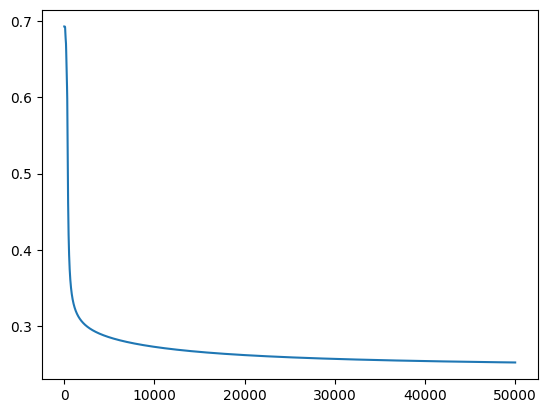

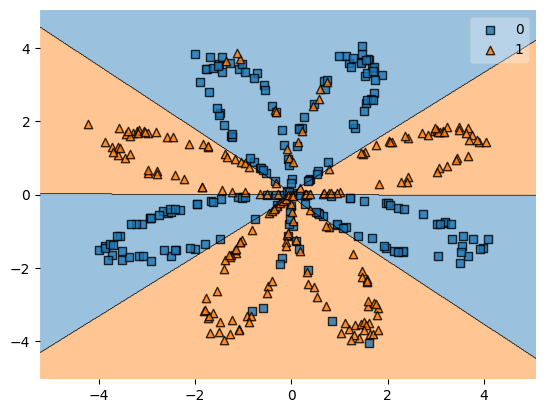

Best model with hidden size 3 and accuracy 0.9125
Model with hidden size 5, lr 0.01, epochs 100, Train Accuracy: 0.5
Model with hidden size 5, lr 0.01, epochs 10000, Train Accuracy: 0.4925
Model with hidden size 5, lr 0.01, epochs 50000, Train Accuracy: 0.8625
Model with hidden size 5, lr 0.01, epochs 100000, Train Accuracy: 0.8725
Model with hidden size 5, lr 0.1, epochs 100, Train Accuracy: 0.5
Model with hidden size 5, lr 0.1, epochs 10000, Train Accuracy: 0.8825
Model with hidden size 5, lr 0.1, epochs 50000, Train Accuracy: 0.9
Model with hidden size 5, lr 0.1, epochs 100000, Train Accuracy: 0.8875
Model with hidden size 5, lr 1, epochs 100, Train Accuracy: 0.48
Model with hidden size 5, lr 1, epochs 10000, Train Accuracy: 0.89
Model with hidden size 5, lr 1, epochs 50000, Train Accuracy: 0.915
Model with hidden size 5, lr 1, epochs 100000, Train Accuracy: 0.915
Model with hidden size 5, lr 10, epochs 100, Train Accuracy: 0.59
Model with hidden size 5, lr 10, epochs 10000, Train A

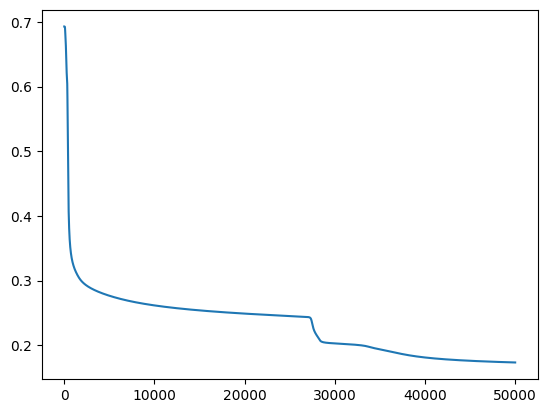

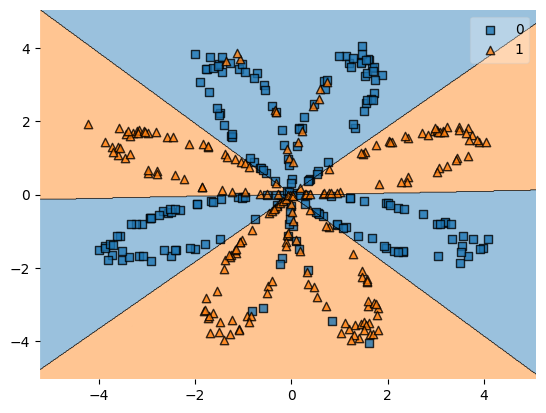

Best model with hidden size 5 and accuracy 0.915
Model with hidden size 10, lr 0.01, epochs 100, Train Accuracy: 0.5
Model with hidden size 10, lr 0.01, epochs 10000, Train Accuracy: 0.4875
Model with hidden size 10, lr 0.01, epochs 50000, Train Accuracy: 0.8575
Model with hidden size 10, lr 0.01, epochs 100000, Train Accuracy: 0.87
Model with hidden size 10, lr 0.1, epochs 100, Train Accuracy: 0.5
Model with hidden size 10, lr 0.1, epochs 10000, Train Accuracy: 0.875
Model with hidden size 10, lr 0.1, epochs 50000, Train Accuracy: 0.88
Model with hidden size 10, lr 0.1, epochs 100000, Train Accuracy: 0.8975
Model with hidden size 10, lr 1, epochs 100, Train Accuracy: 0.4825
Model with hidden size 10, lr 1, epochs 10000, Train Accuracy: 0.9
Model with hidden size 10, lr 1, epochs 50000, Train Accuracy: 0.91
Model with hidden size 10, lr 1, epochs 100000, Train Accuracy: 0.915
Model with hidden size 10, lr 10, epochs 100, Train Accuracy: 0.585
Model with hidden size 10, lr 10, epochs 10

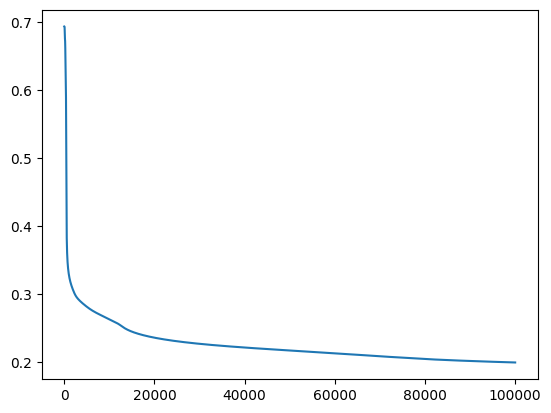

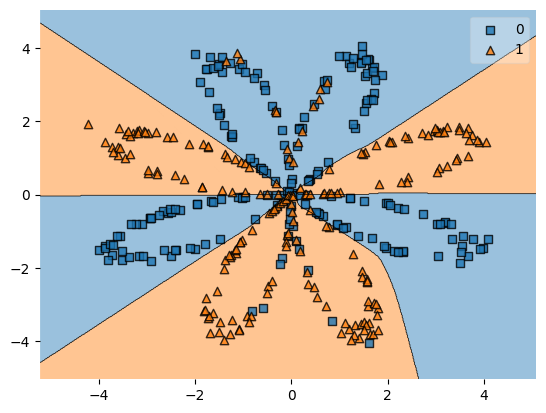

Best model with hidden size 10 and accuracy 0.915
Model with hidden size 3, lr 0.01, epochs 100, Train Accuracy: 0.5
Model with hidden size 3, lr 0.01, epochs 10000, Train Accuracy: 0.815
Model with hidden size 3, lr 0.01, epochs 50000, Train Accuracy: 0.86
Model with hidden size 3, lr 0.01, epochs 100000, Train Accuracy: 0.8575
Model with hidden size 3, lr 0.1, epochs 100, Train Accuracy: 0.5
Model with hidden size 3, lr 0.1, epochs 10000, Train Accuracy: 0.8625
Model with hidden size 3, lr 0.1, epochs 50000, Train Accuracy: 1.0
Model with hidden size 3, lr 0.1, epochs 100000, Train Accuracy: 1.0
Model with hidden size 3, lr 1, epochs 100, Train Accuracy: 0.8
Model with hidden size 3, lr 1, epochs 10000, Train Accuracy: 1.0
Model with hidden size 3, lr 1, epochs 50000, Train Accuracy: 1.0
Model with hidden size 3, lr 1, epochs 100000, Train Accuracy: 1.0
Model with hidden size 3, lr 10, epochs 100, Train Accuracy: 0.845
Model with hidden size 3, lr 10, epochs 10000, Train Accuracy: 0.

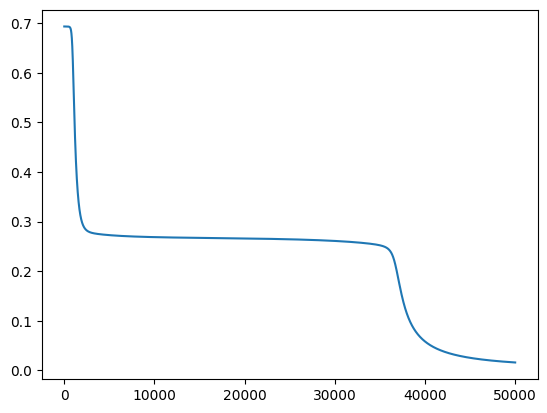

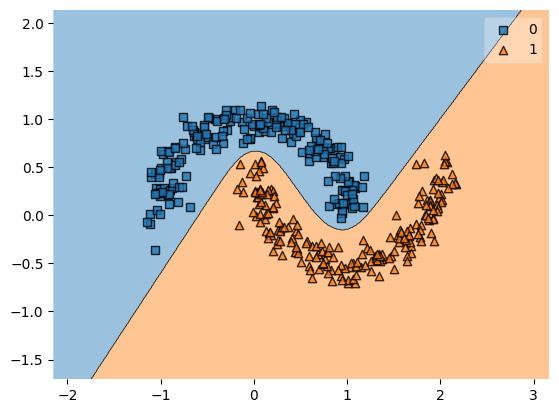

Best model with hidden size 3 and accuracy 1.0
Model with hidden size 5, lr 0.01, epochs 100, Train Accuracy: 0.5
Model with hidden size 5, lr 0.01, epochs 10000, Train Accuracy: 0.825
Model with hidden size 5, lr 0.01, epochs 50000, Train Accuracy: 0.8625
Model with hidden size 5, lr 0.01, epochs 100000, Train Accuracy: 0.8625
Model with hidden size 5, lr 0.1, epochs 100, Train Accuracy: 0.5
Model with hidden size 5, lr 0.1, epochs 10000, Train Accuracy: 0.8625
Model with hidden size 5, lr 0.1, epochs 50000, Train Accuracy: 0.8625
Model with hidden size 5, lr 0.1, epochs 100000, Train Accuracy: 1.0
Model with hidden size 5, lr 1, epochs 100, Train Accuracy: 0.805
Model with hidden size 5, lr 1, epochs 10000, Train Accuracy: 1.0
Model with hidden size 5, lr 1, epochs 50000, Train Accuracy: 1.0
Model with hidden size 5, lr 1, epochs 100000, Train Accuracy: 1.0
Model with hidden size 5, lr 10, epochs 100, Train Accuracy: 0.855
Model with hidden size 5, lr 10, epochs 10000, Train Accuracy

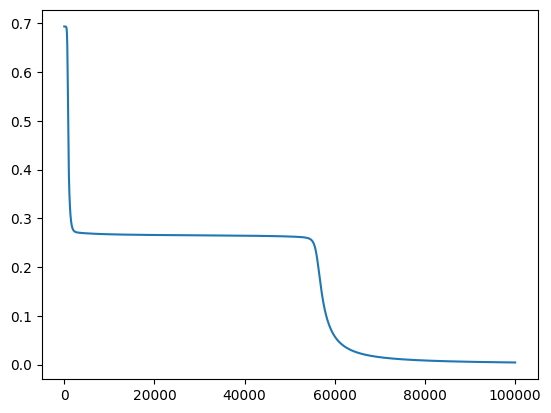

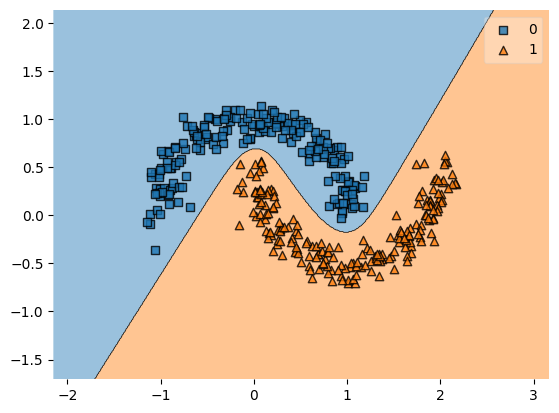

Best model with hidden size 5 and accuracy 1.0
Model with hidden size 10, lr 0.01, epochs 100, Train Accuracy: 0.5
Model with hidden size 10, lr 0.01, epochs 10000, Train Accuracy: 0.8275
Model with hidden size 10, lr 0.01, epochs 50000, Train Accuracy: 0.8625
Model with hidden size 10, lr 0.01, epochs 100000, Train Accuracy: 0.8625
Model with hidden size 10, lr 0.1, epochs 100, Train Accuracy: 0.5
Model with hidden size 10, lr 0.1, epochs 10000, Train Accuracy: 0.8625
Model with hidden size 10, lr 0.1, epochs 50000, Train Accuracy: 0.8625
Model with hidden size 10, lr 0.1, epochs 100000, Train Accuracy: 0.8625
Model with hidden size 10, lr 1, epochs 100, Train Accuracy: 0.815
Model with hidden size 10, lr 1, epochs 10000, Train Accuracy: 0.86
Model with hidden size 10, lr 1, epochs 50000, Train Accuracy: 0.8625
Model with hidden size 10, lr 1, epochs 100000, Train Accuracy: 1.0
Model with hidden size 10, lr 10, epochs 100, Train Accuracy: 0.8725
Model with hidden size 10, lr 10, epoch

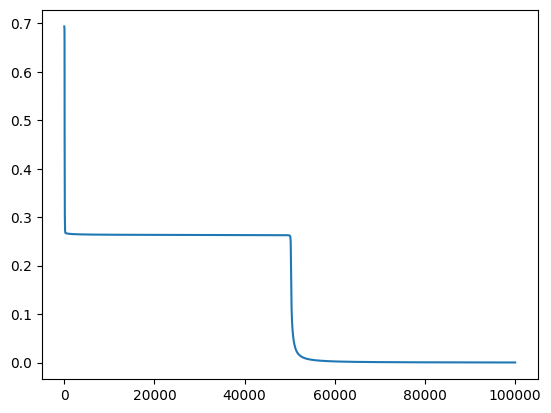

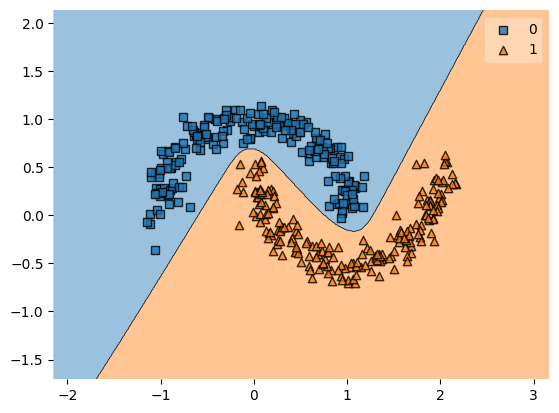

Best model with hidden size 10 and accuracy 1.0
Model with hidden size 3, lr 0.01, epochs 100, Train Accuracy: 0.5
Model with hidden size 3, lr 0.01, epochs 10000, Train Accuracy: 0.5
Model with hidden size 3, lr 0.01, epochs 50000, Train Accuracy: 0.5075
Model with hidden size 3, lr 0.01, epochs 100000, Train Accuracy: 0.495
Model with hidden size 3, lr 0.1, epochs 100, Train Accuracy: 0.5
Model with hidden size 3, lr 0.1, epochs 10000, Train Accuracy: 0.515
Model with hidden size 3, lr 0.1, epochs 50000, Train Accuracy: 0.5225
Model with hidden size 3, lr 0.1, epochs 100000, Train Accuracy: 0.4975
Model with hidden size 3, lr 1, epochs 100, Train Accuracy: 0.5
Model with hidden size 3, lr 1, epochs 10000, Train Accuracy: 0.4975
Model with hidden size 3, lr 1, epochs 50000, Train Accuracy: 0.8175
Model with hidden size 3, lr 1, epochs 100000, Train Accuracy: 0.82
Model with hidden size 3, lr 10, epochs 100, Train Accuracy: 0.5
Model with hidden size 3, lr 10, epochs 10000, Train Accur

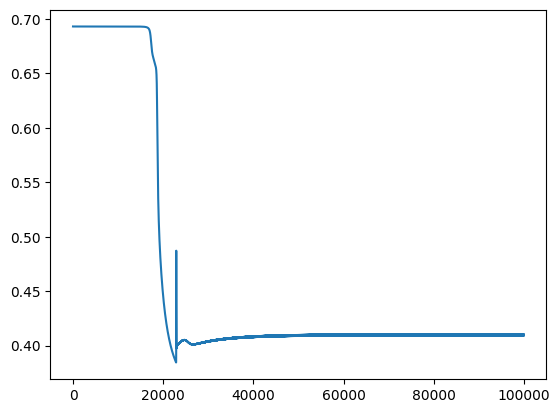

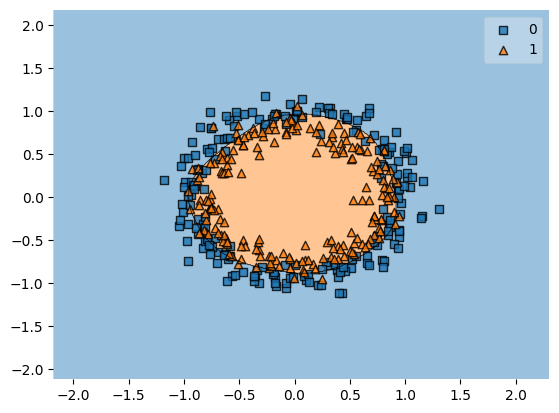

Best model with hidden size 3 and accuracy 0.82
Model with hidden size 5, lr 0.01, epochs 100, Train Accuracy: 0.5
Model with hidden size 5, lr 0.01, epochs 10000, Train Accuracy: 0.515
Model with hidden size 5, lr 0.01, epochs 50000, Train Accuracy: 0.4825
Model with hidden size 5, lr 0.01, epochs 100000, Train Accuracy: 0.5025
Model with hidden size 5, lr 0.1, epochs 100, Train Accuracy: 0.5
Model with hidden size 5, lr 0.1, epochs 10000, Train Accuracy: 0.5075
Model with hidden size 5, lr 0.1, epochs 50000, Train Accuracy: 0.5025
Model with hidden size 5, lr 0.1, epochs 100000, Train Accuracy: 0.5
Model with hidden size 5, lr 1, epochs 100, Train Accuracy: 0.4375
Model with hidden size 5, lr 1, epochs 10000, Train Accuracy: 0.5
Model with hidden size 5, lr 1, epochs 50000, Train Accuracy: 0.84
Model with hidden size 5, lr 1, epochs 100000, Train Accuracy: 0.845
Model with hidden size 5, lr 10, epochs 100, Train Accuracy: 0.5
Model with hidden size 5, lr 10, epochs 10000, Train Accur

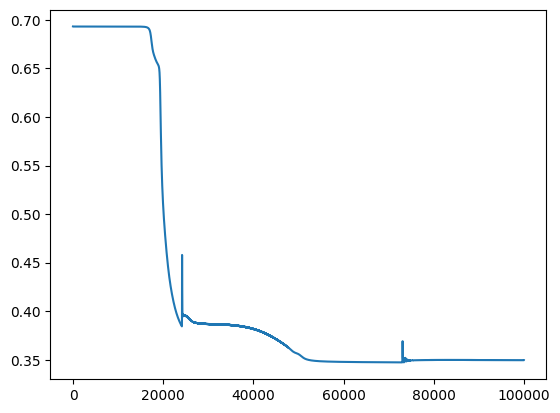

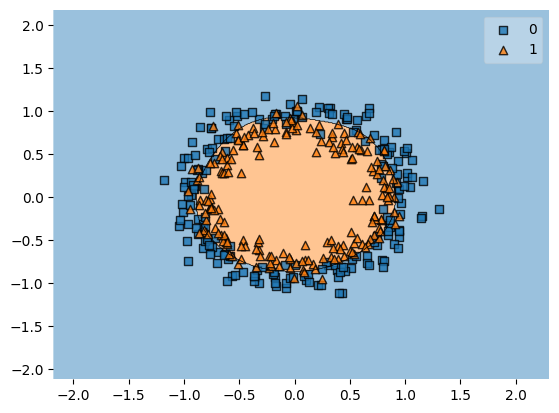

Best model with hidden size 5 and accuracy 0.845
Model with hidden size 10, lr 0.01, epochs 100, Train Accuracy: 0.5
Model with hidden size 10, lr 0.01, epochs 10000, Train Accuracy: 0.4225
Model with hidden size 10, lr 0.01, epochs 50000, Train Accuracy: 0.51
Model with hidden size 10, lr 0.01, epochs 100000, Train Accuracy: 0.5
Model with hidden size 10, lr 0.1, epochs 100, Train Accuracy: 0.525
Model with hidden size 10, lr 0.1, epochs 10000, Train Accuracy: 0.5125
Model with hidden size 10, lr 0.1, epochs 50000, Train Accuracy: 0.4975
Model with hidden size 10, lr 0.1, epochs 100000, Train Accuracy: 0.5
Model with hidden size 10, lr 1, epochs 100, Train Accuracy: 0.4775
Model with hidden size 10, lr 1, epochs 10000, Train Accuracy: 0.5
Model with hidden size 10, lr 1, epochs 50000, Train Accuracy: 0.8275
Model with hidden size 10, lr 1, epochs 100000, Train Accuracy: 0.8425
Model with hidden size 10, lr 10, epochs 100, Train Accuracy: 0.5
Model with hidden size 10, lr 10, epochs 10

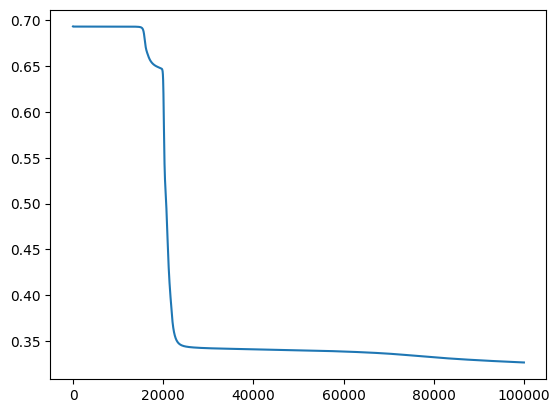

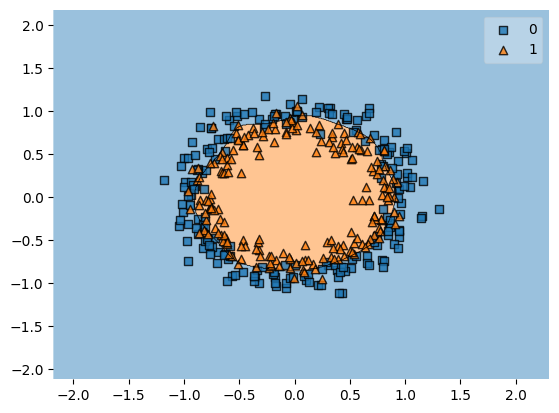

Best model with hidden size 10 and accuracy 0.8425


In [80]:
def evaluate_model(model, x, y):
    y_pred = model.predict(x)
    accuracy = np.mean(y_pred == y)
    return accuracy


x_moons, y_moons = make_moons(n_samples=400, noise=0.1, random_state=42)
x_circles, y_circles = make_circles(n_samples=400, noise=0.1, random_state=42)

dataset_x = [x, x_moons, x_circles]
dataset_y = [y, y_moons, y_circles]

learning_rate = [ 0.01, 0.1, 1, 10]
epochs = [100, 10000, 50000, 100000]
hidden_layer = [3, 5, 10]

for i in range (3):
  currX = dataset_x[i]
  currY = dataset_y[i]

  currY = currY.reshape(-1,1)
  for layer in hidden_layer:
    best_accuracy = 0
    for lr_i in learning_rate:
      for epoch_j in epochs:
          model = MyNN(input_size=2, hidden_size=layer, output_size=1)
          model.fit(currX, currY, lr=lr_i, n_epoch=epoch_j)

          accuracy = evaluate_model(model, currX, currY)
          if accuracy > best_accuracy:
            best_model = model
            best_accuracy = accuracy

          print(f"Model with hidden size {layer}, lr {lr_i}, epochs {epoch_j}, Train Accuracy: {accuracy}")
    plt.plot(best_model.loss_array)
    plt.show()

    plot_decision_regions(currX,currY.reshape(-1,),best_model)
    plt.show()
    print(f"Best model with hidden size {best_model.hidden_size} and accuracy {best_accuracy}")



# **Question 5 Answer**
***There were some oscillations or jumps during the learning process. For example when training "Best model with hidden size 5 and accuracy 0.915" for the petal, you can see theres a slight jump at ~30,000. If you look at "Best model with hidden size 3 and accuracy 0.82" for the circles, near ~20,000 theres a huge spike/oscillation.***

***This might be because the algorithm is struggling to converge, represented by the loss function failing to stabilize. It can also be cause by too large of a learning rate. This indicates instability in the training process.***

***The loss function is convex with respect to 'W' and bias 'b', if we disregard the oscillations caused by the instability. There are no local/global mins/maxs.***